In [1]:
# ────────────────────────────────
# 1. IMPORTS
# ────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

# ────────────────────────────────
# 2. LOAD AND PREPARE RAW DATA
# ────────────────────────────────
df = pd.read_csv('1_es.txt')
df.columns = df.columns.str.strip().str.lower()

df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.set_index('datetime', inplace=True)
df.drop(columns=['date', 'time'], inplace=True)
df.sort_index(inplace=True)

# Filter valid sessions (07:00 – 15:59 only, 540 buckets per valid day)
df = df.between_time('07:00', '15:59')
session_counts = df.groupby(df.index.normalize()).size()
valid_dates = session_counts[session_counts == 540].index
df = df[df.index.normalize().isin(valid_dates)].copy()

# Aggregate into 2-minute buckets
df['bucket'] = df.index.floor('2min')
df = df.groupby('bucket').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'last': 'last',
    'volume': 'sum',
    'numberoftrades': 'sum',
    'bidvolume': 'sum',
    'askvolume': 'sum'
}).sort_index().copy()

df['date'] = df.index.date

# ────────────────────────────────
# 3. BAIR CALCULATIONS
# ────────────────────────────────
df['cum_bid'] = df.groupby('date')['bidvolume'].cumsum()
df['cum_ask'] = df.groupby('date')['askvolume'].cumsum()
df['cum_bair'] = (df['cum_bid'] - df['cum_ask']) / (df['cum_bid'] + df['cum_ask'])

# ────────────────────────────────
# 4. PLOTTING FUNCTION
# ────────────────────────────────
def plot_tpo_bair_candles(date_str, tick=0.25, band_size=4):
    """
    Plot comprehensive TPO & candlestick views:
      0. Traditional TPO (prev PIT): time-based TPO with POC, VAH, VAL, High, Low
      1. Full-session Volume TPO (prev day)
      2. Full-session BAIR TPO (prev day)
      3. Pre-market Volume TPO (current day)
      4. Pre-market BAIR TPO (current day)
      5. Candlestick (current day) with all POCs + daily high/low
      6. Full-session BAIR TPO (pit session, current day)
      7. Separate cumulative BAIR (pit session)
    """
    tick_band = tick * band_size
    target_date = pd.to_datetime(date_str).date()
    
    # -------------------------
    # Filter data
    # -------------------------
    sample_day = df[df['date'] == target_date].copy()
    pre_market = sample_day.between_time('07:00', '09:30').copy()
    full_session_today = sample_day.between_time('07:00', '15:58').copy()
    full_session_today_pit = full_session_today.between_time('09:30', '15:58').copy()
    
    prev_day = df[df['date'] < target_date]['date'].max()
    full_session_prev = df[df['date'] == prev_day].between_time('07:00', '15:58').copy()
    # previous-day PIT session for traditional TPO
    prev_pit = df[df['date'] == prev_day].between_time('09:30', '15:58').copy()

    # -------------------------
    # Traditional TPO (time-based) for previous PIT session
    # -------------------------
    def build_time_tpo_counts(session_df, tick_size):
        if session_df.empty:
            return pd.Series(dtype=int)
        session_df = session_df.sort_index()
        pmin = np.floor(session_df['low'].min() / tick_size) * tick_size
        pmax = np.ceil(session_df['high'].max() / tick_size) * tick_size
        price_grid = np.round(np.arange(pmin, pmax + tick_size, tick_size), 10)
        counts = {p: 0 for p in price_grid}
        for _, row in session_df.iterrows():
            low_step = np.floor(row['low'] / tick_size) * tick_size
            high_step = np.ceil(row['high'] / tick_size) * tick_size
            levels = np.round(np.arange(low_step, high_step + tick_size, tick_size), 10)
            for p in levels:
                if p in counts:
                    counts[p] += 1
        s = pd.Series(counts)
        s = s[s > 0].sort_index()
        return s

    tpo_counts_prev_pit = build_time_tpo_counts(prev_pit, tick)

    def compute_value_area(counts, tick_size):
        if counts.empty:
            return np.nan, np.nan, np.nan
        poc = counts.idxmax()
        total = counts.sum()
        target = 0.7 * total
        grid = np.round(np.arange(counts.index.min(), counts.index.max() + tick_size, tick_size), 10)
        full = pd.Series(0, index=grid)
        full.loc[counts.index] = counts.values
        full = full.sort_index()
        poc_idx = full.index.get_indexer([poc])[0]
        val = vah = poc
        covered = full.iloc[poc_idx]
        left = poc_idx - 1
        right = poc_idx + 1
        while covered < target and (left >= 0 or right < len(full)):
            left_val = full.iloc[left] if left >= 0 else -1
            right_val = full.iloc[right] if right < len(full) else -1
            if right_val >= left_val:
                covered += max(right_val, 0)
                vah = full.index[right]
                right += 1
            else:
                covered += max(left_val, 0)
                val = full.index[left]
                left -= 1
        return poc, vah, val

    tpo_poc_prev, tpo_vah_prev, tpo_val_prev = compute_value_area(tpo_counts_prev_pit, tick)
    prev_day_high = prev_pit['high'].max() if not prev_pit.empty else np.nan
    prev_day_low  = prev_pit['low'].min() if not prev_pit.empty else np.nan

    # -------------------------
    # Compute TPOs for other panels
    # -------------------------
    pre_market['price_bucket_bair'] = (pre_market['last'] / tick_band).round() * tick_band
    pre_market['bair_delta'] = pre_market['cum_bair'].diff().fillna(pre_market['cum_bair'])
    bair_tpo_pm = pre_market.groupby('price_bucket_bair')['bair_delta'].sum()
    bair_poc_pm = bair_tpo_pm.abs().idxmax() if not bair_tpo_pm.empty else np.nan

    volume_tpo_pm = pre_market.groupby((pre_market['last']/tick_band).round()*tick_band)['volume'].sum()
    volume_poc_pm = volume_tpo_pm.idxmax() if not volume_tpo_pm.empty else np.nan

    full_session_prev['price_bucket_bair'] = (full_session_prev['last'] / tick_band).round() * tick_band
    full_session_prev['bair_delta'] = full_session_prev['cum_bair'].diff().fillna(full_session_prev['cum_bair'])
    bair_tpo_fs = full_session_prev.groupby('price_bucket_bair')['bair_delta'].sum()
    bair_poc_fs = bair_tpo_fs.abs().idxmax() if not bair_tpo_fs.empty else np.nan

    volume_tpo_fs = full_session_prev.groupby((full_session_prev['last']/tick_band).round()*tick_band)['volume'].sum()
    volume_poc_fs = volume_tpo_fs.idxmax() if not volume_tpo_fs.empty else np.nan

    full_session_today_pit['price_bucket_bair'] = (full_session_today_pit['last'] / tick_band).round() * tick_band
    full_session_today_pit['bair_delta'] = full_session_today_pit['cum_bair'].diff().fillna(full_session_today_pit['cum_bair'])
    bair_tpo_today = full_session_today_pit.groupby('price_bucket_bair')['bair_delta'].sum()
    bair_poc_today = bair_tpo_today.abs().idxmax() if not bair_tpo_today.empty else np.nan

    # -------------------------
    # Helper: Shade POC band
    # -------------------------
    def shade_poc_band(ax, poc, color, alpha=0.15):
        if np.isnan(poc):
            return
        band = poc * 0.0005
        lower = poc - band/2
        upper = poc + band/2
        ax.axhspan(lower, upper, color=color, alpha=alpha)

    # -------------------------
    # Plot TPOs + Candlestick (7 panels)
    # -------------------------
    fig, axes = plt.subplots(
        1, 7, figsize=(42,8),
        gridspec_kw={'width_ratios':[1,1,1,1,1,4,1]}, sharey=True
    )

    # 0. Traditional TPO (prev PIT)
    axes[0].barh(tpo_counts_prev_pit.index, tpo_counts_prev_pit.values,
                 height=tick*0.8, color='saddlebrown', alpha=0.6)
    if not np.isnan(tpo_poc_prev):
        axes[0].axhline(tpo_poc_prev, color='saddlebrown', linestyle='--', linewidth=1.5, label=f'POC: {tpo_poc_prev}')
        shade_poc_band(axes[0], tpo_poc_prev, 'saddlebrown')
    if not np.isnan(tpo_vah_prev):
        axes[0].axhline(tpo_vah_prev, color='green', linestyle='-.', linewidth=1, label=f'VAH: {tpo_vah_prev}')
    if not np.isnan(tpo_val_prev):
        axes[0].axhline(tpo_val_prev, color='green', linestyle='-.', linewidth=1, label=f'VAL: {tpo_val_prev}')
    if not np.isnan(prev_day_high):
        axes[0].axhline(prev_day_high, color='black', linestyle=':', linewidth=1, label=f'High: {prev_day_high}')
    if not np.isnan(prev_day_low):
        axes[0].axhline(prev_day_low, color='black', linestyle=':', linewidth=1, label=f'Low: {prev_day_low}')
    axes[0].set_xlabel("TPO (time prints)")
    axes[0].set_title(f"Traditional TPO (Time) – PIT {prev_day}")
    axes[0].legend(loc='lower right', fontsize=8)
    axes[0].set_ylabel("Price")

    # 1–4. Other TPO panels (unchanged)
    axes[1].barh(volume_tpo_fs.index, volume_tpo_fs.values, height=tick_band*0.8, color='orange', alpha=0.6)
    if not np.isnan(volume_poc_fs):
        axes[1].axhline(volume_poc_fs, color='orange', linestyle='--', linewidth=1)
        shade_poc_band(axes[1], volume_poc_fs, 'orange')
    axes[1].set_xlabel("Volume")
    axes[1].set_title(f"Full-Session Volume-TPO\n({tick_band} tick bands) – {prev_day}")

    axes[2].barh(bair_tpo_fs.index, bair_tpo_fs.values, height=tick_band*0.8, color='blue', alpha=0.6)
    if not np.isnan(bair_poc_fs):
        axes[2].axhline(bair_poc_fs, color='blue', linestyle='--', linewidth=1)
        shade_poc_band(axes[2], bair_poc_fs, 'blue')
    axes[2].axvline(0, color='gray', linestyle='-', linewidth=1)
    axes[2].set_xlabel("BAIR Delta (sum)")
    axes[2].set_title(f"Full-Session BAIR-TPO\n({tick_band} tick bands) – {prev_day}")

    axes[3].barh(volume_tpo_pm.index, volume_tpo_pm.values, height=tick_band*0.8, color='green', alpha=0.6)
    if not np.isnan(volume_poc_pm):
        axes[3].axhline(volume_poc_pm, color='green', linestyle='--', linewidth=1)
        shade_poc_band(axes[3], volume_poc_pm, 'green')
    axes[3].set_xlabel("Volume")
    axes[3].set_title(f"Pre-Market Volume-TPO\n({tick_band} tick bands)")

    axes[4].barh(bair_tpo_pm.index, bair_tpo_pm.values, height=tick_band*0.8, color='purple', alpha=0.6)
    if not np.isnan(bair_poc_pm):
        axes[4].axhline(bair_poc_pm, color='purple', linestyle='--', linewidth=1)
        shade_poc_band(axes[4], bair_poc_pm, 'purple')
    axes[4].axvline(0, color='gray', linestyle='-', linewidth=1)
    axes[4].set_xlabel("BAIR Delta (sum)")
    axes[4].set_title(f"Pre-Market BAIR-TPO\n({tick_band} tick bands)")

    # 5. Candlestick (current day) with all POCs shaded and daily high/low
    ax = axes[5]
    if len(full_session_today.index) > 1:
        width = np.min(np.diff(full_session_today.index.view('int64'))) / 1.5e9
    else:
        width = 120
    for idx, row in full_session_today.iterrows():
        color = 'green' if row['last'] >= row['open'] else 'red'
        ax.plot([idx, idx], [row['low'], row['high']], color='black', linewidth=1)
        rect = Rectangle(
            (idx - pd.Timedelta(seconds=width/2), min(row['open'], row['last'])),
            width=pd.Timedelta(seconds=width),
            height=abs(row['last'] - row['open']),
            color=color
        )
        ax.add_patch(rect)

    # POCs with shading
    poc_list = [
        (tpo_poc_prev, 'saddlebrown'),
        (volume_poc_fs, 'orange'),
        (bair_poc_fs, 'blue'),
        (volume_poc_pm, 'green'),
        (bair_poc_pm, 'purple'),
        (bair_poc_today, 'grey')
    ]
    for poc, color in poc_list:
        if not np.isnan(poc):
            ax.axhline(poc, color=color, linestyle='--', linewidth=1)
            shade_poc_band(ax, poc, color)

    # Daily high/low lines (grey, no shading)
    if not np.isnan(prev_day_high):
        ax.axhline(prev_day_high, color='grey', linestyle=':', linewidth=1, label='Prev PIT High')
    if not np.isnan(prev_day_low):
        ax.axhline(prev_day_low, color='grey', linestyle=':', linewidth=1, label='Prev PIT Low')

    pre_market_end = pd.to_datetime(f"{date_str} 09:30")
    ax.axvline(pre_market_end, color='black', linestyle=':', linewidth=2, label='09:30')
    ax.set_xlabel("Time")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.legend(loc='upper left', fontsize=8)
    ax.set_title(f"Candlestick – {target_date}")

    # 6. Full-Session BAIR-TPO (current day pit)
    axes[6].barh(bair_tpo_today.index, bair_tpo_today.values, height=tick_band*0.8, color='grey', alpha=0.6)
    if not np.isnan(bair_poc_today):
        axes[6].axhline(bair_poc_today, color='black', linestyle='--', linewidth=1)
        shade_poc_band(axes[6], bair_poc_today, 'grey')
    axes[6].axvline(0, color='gray', linestyle='-', linewidth=1)
    axes[6].set_xlabel("BAIR Delta (sum)")
    axes[6].set_title(f"Full-Session BAIR-TPO\n({tick_band} tick bands) – {target_date}")

    plt.suptitle(f"Traditional TPO (Prev PIT) + TPO/BAIR & Candlesticks – {target_date}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # 7. Separate: Cumulative BAIR (pit session)
    sample_pit = full_session_today_pit.copy()
    fig2, ax2 = plt.subplots(figsize=(12,6))
    ax2.plot(sample_pit.index, sample_pit['cum_bair'], color='blue', label='Cumulative BAIR')
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    ax2.set_title(f"Cumulative BAIR – {target_date} (09:30–15:58)")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("BAIR (Bid-Ask Imbalance Ratio)")
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax2.legend()

    plt.show()

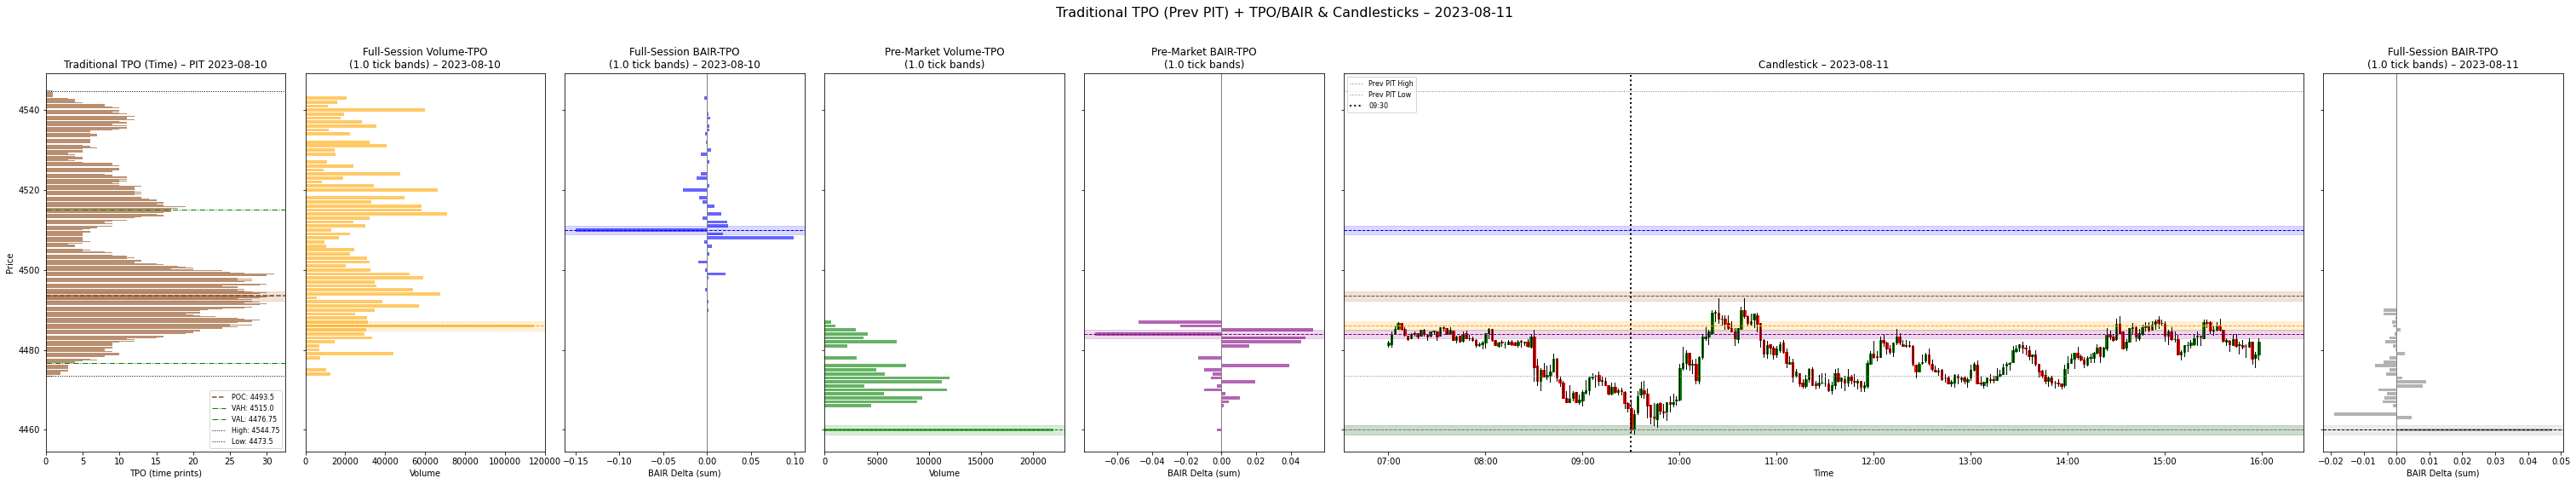

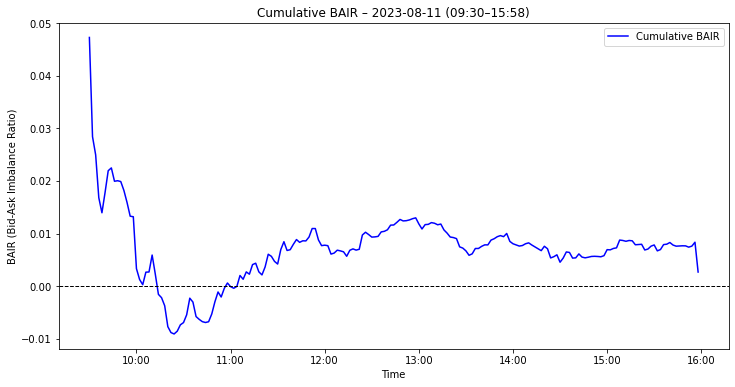

In [2]:
# ────────────────────────────────
# 5. RUN EXAMPLE
# ────────────────────────────────
plot_tpo_bair_candles("2023-08-11")

In [3]:
def summarize_daily_tpo_with_traditional(df, tick=0.25, band_size=4):
    tick_band = tick * band_size
    results = []

    all_dates = sorted(df['date'].unique())
    for date in all_dates[1:]:  # skip first day (needs prev day)
        target_date = pd.to_datetime(date).date()
        prev_day = df.loc[df['date'] < target_date, 'date'].max()

        # -------------------------
        # Filter sessions
        # -------------------------
        pre_market = df[df['date'] == target_date].between_time('07:00', '09:30').copy()
        full_session_prev = df[df['date'] == prev_day].between_time('07:00', '15:58').copy()
        full_session_today_pit = df[df['date'] == target_date].between_time('09:30', '15:58').copy()
        prev_pit = df[df['date'] == prev_day].between_time('09:30', '15:58').copy()

        # -------------------------
        # Traditional TPO (time-based) – previous PIT
        # -------------------------
        def build_time_tpo_counts(session_df, tick_size):
            if session_df.empty:
                return pd.Series(dtype=int)
            session_df = session_df.sort_index()
            pmin = np.floor(session_df['low'].min() / tick_size) * tick_size
            pmax = np.ceil(session_df['high'].max() / tick_size) * tick_size
            price_grid = np.round(np.arange(pmin, pmax + tick_size, tick_size), 10)
            counts = {p: 0 for p in price_grid}
            for _, row in session_df.iterrows():
                low_step = np.floor(row['low'] / tick_size) * tick_size
                high_step = np.ceil(row['high'] / tick_size) * tick_size
                levels = np.round(np.arange(low_step, high_step + tick_size, tick_size), 10)
                for p in levels:
                    if p in counts:
                        counts[p] += 1
            s = pd.Series(counts)
            s = s[s > 0].sort_index()
            return s

        tpo_counts_prev_pit = build_time_tpo_counts(prev_pit, tick)

        def compute_value_area(counts, tick_size):
            if counts.empty:
                return np.nan, np.nan, np.nan
            poc = counts.idxmax()
            total = counts.sum()
            target = 0.7 * total
            grid = np.round(np.arange(counts.index.min(), counts.index.max() + tick_size, tick_size), 10)
            full = pd.Series(0, index=grid)
            full.loc[counts.index] = counts.values
            full = full.sort_index()
            poc_idx = full.index.get_indexer([poc])[0]
            val = vah = poc
            covered = full.iloc[poc_idx]
            left = poc_idx - 1
            right = poc_idx + 1
            while covered < target and (left >= 0 or right < len(full)):
                left_val = full.iloc[left] if left >= 0 else -1
                right_val = full.iloc[right] if right < len(full) else -1
                if right_val >= left_val:
                    covered += max(right_val, 0)
                    vah = full.index[right]
                    right += 1
                else:
                    covered += max(left_val, 0)
                    val = full.index[left]
                    left -= 1
            return poc, vah, val

        tpo_poc_prev, tpo_vah_prev, tpo_val_prev = compute_value_area(tpo_counts_prev_pit, tick)
        prev_day_high = prev_pit['high'].max() if not prev_pit.empty else np.nan
        prev_day_low  = prev_pit['low'].min() if not prev_pit.empty else np.nan

        # -------------------------
        # Pre-Market Volume & BAIR POCs
        # -------------------------
        volume_tpo_pm = pre_market.groupby((pre_market['last'] / tick_band).round() * tick_band)['volume'].sum()
        volume_poc_pm = volume_tpo_pm.idxmax() if not volume_tpo_pm.empty else np.nan

        pre_market['price_bucket_bair'] = (pre_market['last'] / tick_band).round() * tick_band
        pre_market['bair_delta'] = pre_market['cum_bair'].diff().fillna(pre_market['cum_bair'])
        bair_tpo_pm = pre_market.groupby('price_bucket_bair')['bair_delta'].sum()
        bair_poc_pm = bair_tpo_pm.abs().idxmax() if not bair_tpo_pm.empty else np.nan

        # -------------------------
        # Previous Day Full-Session Volume & BAIR POCs
        # -------------------------
        volume_tpo_fs = full_session_prev.groupby((full_session_prev['last'] / tick_band).round() * tick_band)['volume'].sum()
        volume_poc_fs = volume_tpo_fs.idxmax() if not volume_tpo_fs.empty else np.nan

        full_session_prev['price_bucket_bair'] = (full_session_prev['last'] / tick_band).round() * tick_band
        full_session_prev['bair_delta'] = full_session_prev['cum_bair'].diff().fillna(full_session_prev['cum_bair'])
        bair_tpo_fs = full_session_prev.groupby('price_bucket_bair')['bair_delta'].sum()
        bair_poc_fs = bair_tpo_fs.abs().idxmax() if not bair_tpo_fs.empty else np.nan

        # -------------------------
        # Current Day Pit BAIR POC
        # -------------------------
        full_session_today_pit['price_bucket_bair'] = (full_session_today_pit['last'] / tick_band).round() * tick_band
        full_session_today_pit['bair_delta'] = full_session_today_pit['cum_bair'].diff().fillna(full_session_today_pit['cum_bair'])
        bair_tpo_today = full_session_today_pit.groupby('price_bucket_bair')['bair_delta'].sum()
        bair_poc_today = bair_tpo_today.abs().idxmax() if not bair_tpo_today.empty else np.nan

        # -------------------------
        # Collect
        # -------------------------
        results.append({
            "date": target_date,
            "prev_day": prev_day,
            # Traditional TPO (time-based, prev PIT)
            "Prev PIT POC": tpo_poc_prev,
            "Prev PIT VAH": tpo_vah_prev,
            "Prev PIT VAL": tpo_val_prev,
            "Prev PIT High": prev_day_high,
            "Prev PIT Low": prev_day_low,
            # Volume/BAIR TPOs
            "PM Volume POC": volume_poc_pm,
            "PM BAIR POC": bair_poc_pm,
            "Prev FS Volume POC": volume_poc_fs,
            "Prev FS BAIR POC": bair_poc_fs,
            "Today Pit BAIR POC": bair_poc_today
        })

    return pd.DataFrame(results)

In [4]:
# Example usage
summary_df = summarize_daily_tpo_with_traditional(df)
print(summary_df.head())

         date    prev_day  Prev PIT POC  Prev PIT VAH  Prev PIT VAL  \
0  2018-08-07  2018-08-06       2849.25       2853.00       2843.00   
1  2018-08-08  2018-08-07       2861.25       2862.25       2859.75   
2  2018-08-09  2018-08-08       2859.50       2860.75       2856.25   
3  2018-08-10  2018-08-09       2859.00       2861.00       2857.75   
4  2018-08-13  2018-08-10       2838.00       2840.75       2833.25   

   Prev PIT High  Prev PIT Low  PM Volume POC  PM BAIR POC  \
0        2853.50       2835.50         2857.0       2857.0   
1        2863.75       2855.75         2856.0       2861.0   
2        2862.50       2853.00         2859.0       2858.0   
3        2862.75       2852.25         2838.0       2841.0   
4        2843.00       2826.00         2836.0       2828.0   

   Prev FS Volume POC  Prev FS BAIR POC  Today Pit BAIR POC  
0              2850.0            2843.0              2857.0  
1              2860.0            2857.0              2854.0  
2             

In [5]:
# summary_df.to_csv('daily_tpo_summary.csv', index=False)

In [6]:
summary_df

,date,prev_day,Prev PIT POC,Prev PIT VAH,Prev PIT VAL,Prev PIT High,Prev PIT Low,PM Volume POC,PM BAIR POC,Prev FS Volume POC,Prev FS BAIR POC,Today Pit BAIR POC
0,2018-08-07,2018-08-06,2849.25,2853.00,2843.00,2853.50,2835.50,2857.0,2857.0,2850.0,2843.0,2857.0
1,2018-08-08,2018-08-07,2861.25,2862.25,2859.75,2863.75,2855.75,2856.0,2861.0,2860.0,2857.0,2854.0
2,2018-08-09,2018-08-08,2859.50,2860.75,2856.25,2862.50,2853.00,2859.0,2858.0,2858.0,2861.0,2856.0
3,2018-08-10,2018-08-09,2859.00,2861.00,2857.75,2862.75,2852.25,2838.0,2841.0,2860.0,2858.0,2838.0
4,2018-08-13,2018-08-10,2838.00,2840.75,2833.25,2843.00,2826.00,2836.0,2828.0,2838.0,2841.0,2838.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1485,2024-08-05,2024-08-02,5361.25,5371.25,5342.00,5417.25,5331.75,5142.0,5228.0,5362.0,5421.0,5161.0
1486,2024-08-06,2024-08-05,5242.75,5252.00,5204.50,5279.50,5146.00,5236.0,5266.0,5204.0,5228.0,5240.0
1487,2024-08-07,2024-08-06,5302.25,5326.50,5277.00,5342.00,5221.75,5330.0,5333.0,5265.0,5266.0,5330.0
1488,2024-08-08,2024-08-07,5253.00,5334.00,5230.50,5359.25,5222.25,5279.0,5222.0,5229.0,5333.0,5279.0
